# Historgram and Sliding Window Analysis

In [1]:
# imports
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

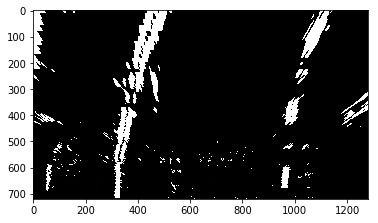

In [2]:
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('warped-example.jpg')/255
plt.imshow(img, cmap='gray')

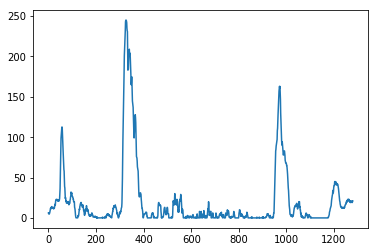

In [3]:
# Create histogram of image binary activations
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

# Visualize the resulting histogram
plt.plot(histogram)

In [4]:
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base, rightx_base)

327 971


### Sliding window

Now that we've set up what the windows look like and have a starting point, we'll want to loop for nwindows, with the given window sliding left or right if it finds the mean position of activated pixels within the window to have shifted.

Here's a few steps to get you started:

1. Loop through each window in nwindows
2. Find the boundaries of our current window. This is based on a combination of the current window's starting point (leftx_current and rightx_current), as well as the margin you set in the hyperparameters.
3. Use cv2.rectangle to draw these window boundaries onto our visualization image out_img. This is required for the quiz, but you can skip this step in practice if you don't need to visualize where the windows are.
4. Now that we know the boundaries of our window, find out which activated pixels from nonzeroy and nonzerox above actually fall into the window.
5. Append these to our lists left_lane_inds and right_lane_inds.
6. If the number of pixels you found in Step 4 are greater than your hyperparameter minpix, re-center our window (i.e. leftx_current or rightx_current) based on the mean position of these pixels.

In [5]:
def find_lane_pixels(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),(0,255,0), 2) 
    
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


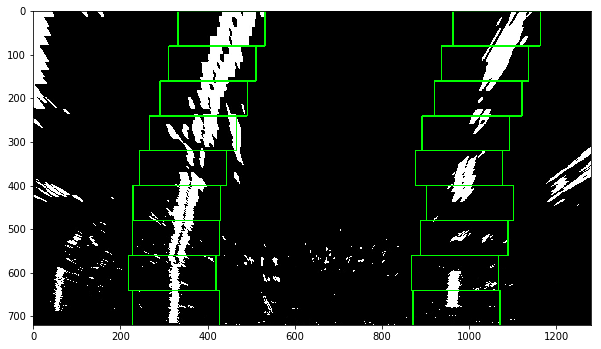

In [6]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
plt.figure(figsize=(10,10))
plt.imshow(out_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


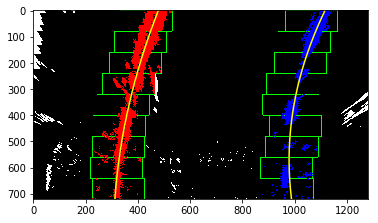

In [7]:
def fit_polynomial(img):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(img)

plt.imshow(out_img)

### Search from Prior

Grab only those pixels with x-values that are +/- your margin from your polynomial lines.

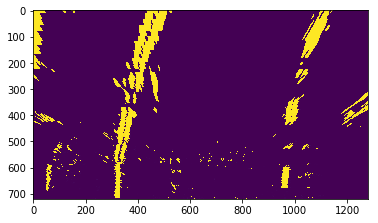

In [8]:
img = mpimg.imread('warped-example.jpg')/255
# Polynomial fit values from the previous frame
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


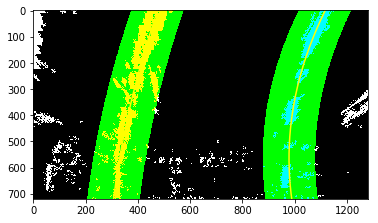

In [9]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(img)

# View your output
plt.imshow(result)

## Sliding window search with convolution

In [13]:
# sliding window settings
window_width = 50
window_height = 80 # 9 vertical slices 720/80=9
margin = 100

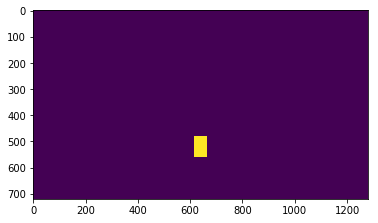

In [50]:
def window_mask(width, height, img_ref, center, level):
    '''
    creates window mask
    width: window width
    height: window height
    center: horizontal center
    level: 0 is the bottom most
    '''
    output = np.zeros_like(img_ref)
    # remember x is vertical and y is horizontal (flipped from norm)
    # vertical slices and it increases downwards
    y = (int(img_ref.shape[0]-(level+1)*height), int(img_ref.shape[0]-level*height))
    # horizontal slices and it increases to the right
    x = (max(0, int(center-width/2)), min(int(center+width/2),img_ref.shape[1]))
    output[y[0]:y[1], x[0]:x[1]] = 1
    return output

center = img.shape[1]//2
mask = window_mask(window_width, window_height, img, center, 2)
plt.imshow(mask)

In [56]:
def find_window_centroids(image, window_width, window_height, margin):
    '''
    find x centroid of each lane per level using convolution on vertical slices
    returns a list of (l_center, r_center) tuple for each level
    '''
    window_centroids = [] # store the left, right window centroid positions per level
    window = np.ones(window_width) # window template for convolution

    # find starting positions of lanes to get vertical image slice
    # use sum of bottom image quadrant in each half of image to get the slice
    l_sum = np.sum(image[int(0.75*image.shape[0]):, :int(image.shape[1]/2)], axis=0)
    r_sum = np.sum(image[int(0.75*image.shape[0]):, int(image.shape[1]/2):], axis=0)
    #  convolve the vertical image slice with window template. The max index represents the center
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
    r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(image.shape[1]/2)
    # we have found the first layer
    window_centroids.append((l_center, r_center))
    
    # go through each layer looking for max pixel locations
    # note we ignore level 0 since we already have it
    for level in range(1, (int)(image.shape[0]/window_height)):
        # get image slice for each level
        y = (int(image.shape[0]-(level+1)*window_height), int(image.shape[0]-level*window_height))
        image_layer = np.sum(image[y, :], axis=0) # sum for each vertical slice
        # covolve the window into the vertical image slice
        conv_signal = np.convolve(window, image_layer)
        # Use window_width/2 as offset because convolution signal reference is at right side of window
        offset = window_width/2
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    
    return window_centroids

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


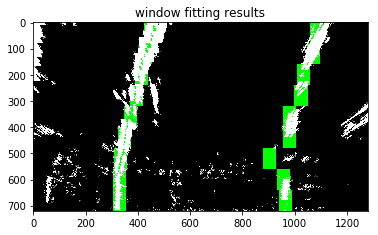

In [66]:
window_centroids = find_window_centroids(img, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(img)
    r_points = np.zeros_like(img)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | (l_mask == 1)] = 255
        r_points[(r_points == 255) | (r_mask == 1)] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    imgpage = np.dstack((img, img, img))*255 # making the original road pixels 3 color channels
    output = imgpage * 0.3 + template * 0.7
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((img,img,img)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()